<a href="https://colab.research.google.com/github/megatAhmad/sma_2023_oct/blob/main/Python_MissingValueAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Missing Value Analysis - Identification and Treatment

In [42]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

In [2]:
data_original = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')
data_original = data_original.replace('?', np.nan)

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data_original['cabin'] = data_original['cabin'].apply(get_first_cabin)

data_original.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22,S,NaN,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


# Vizualizing Missingness

Source : https://towardsdatascience.com/using-the-missingno-python-library-to-identify-and-visualise-missing-data-prior-to-machine-learning-34c8c5b5f009

In [3]:
data = data_original.copy()
data = data[["age", "fare", "survived"]]
data.head()

,age,fare,survived
0,29,211.3375,1
1,0.9167,151.55,1
2,2,151.55,0
3,30,151.55,0
4,25,151.55,0


### Method 1: isna() & sum()

This returns a summary of how many missing values are contained within the dataframe. 

The isna() part detects missing values within the dataframe and returns a Boolean value for each element in the dataframe. 

The sum() part sums up the number of True values.

In [4]:
data.isna().sum()

age         263
fare          1
survived      0
dtype: int64

In [5]:
data.isnull().sum().sort_values(ascending=False)/len(data)*100

age         20.091673
fare         0.076394
survived     0.000000
dtype: float64

### Method 2: Barplot

The barplot provides a simple plot where each bar represents a column within the dataframe. 

The height of the bar indicates how complete that column is, i.e, how many non-null values are present.

<Axes: >

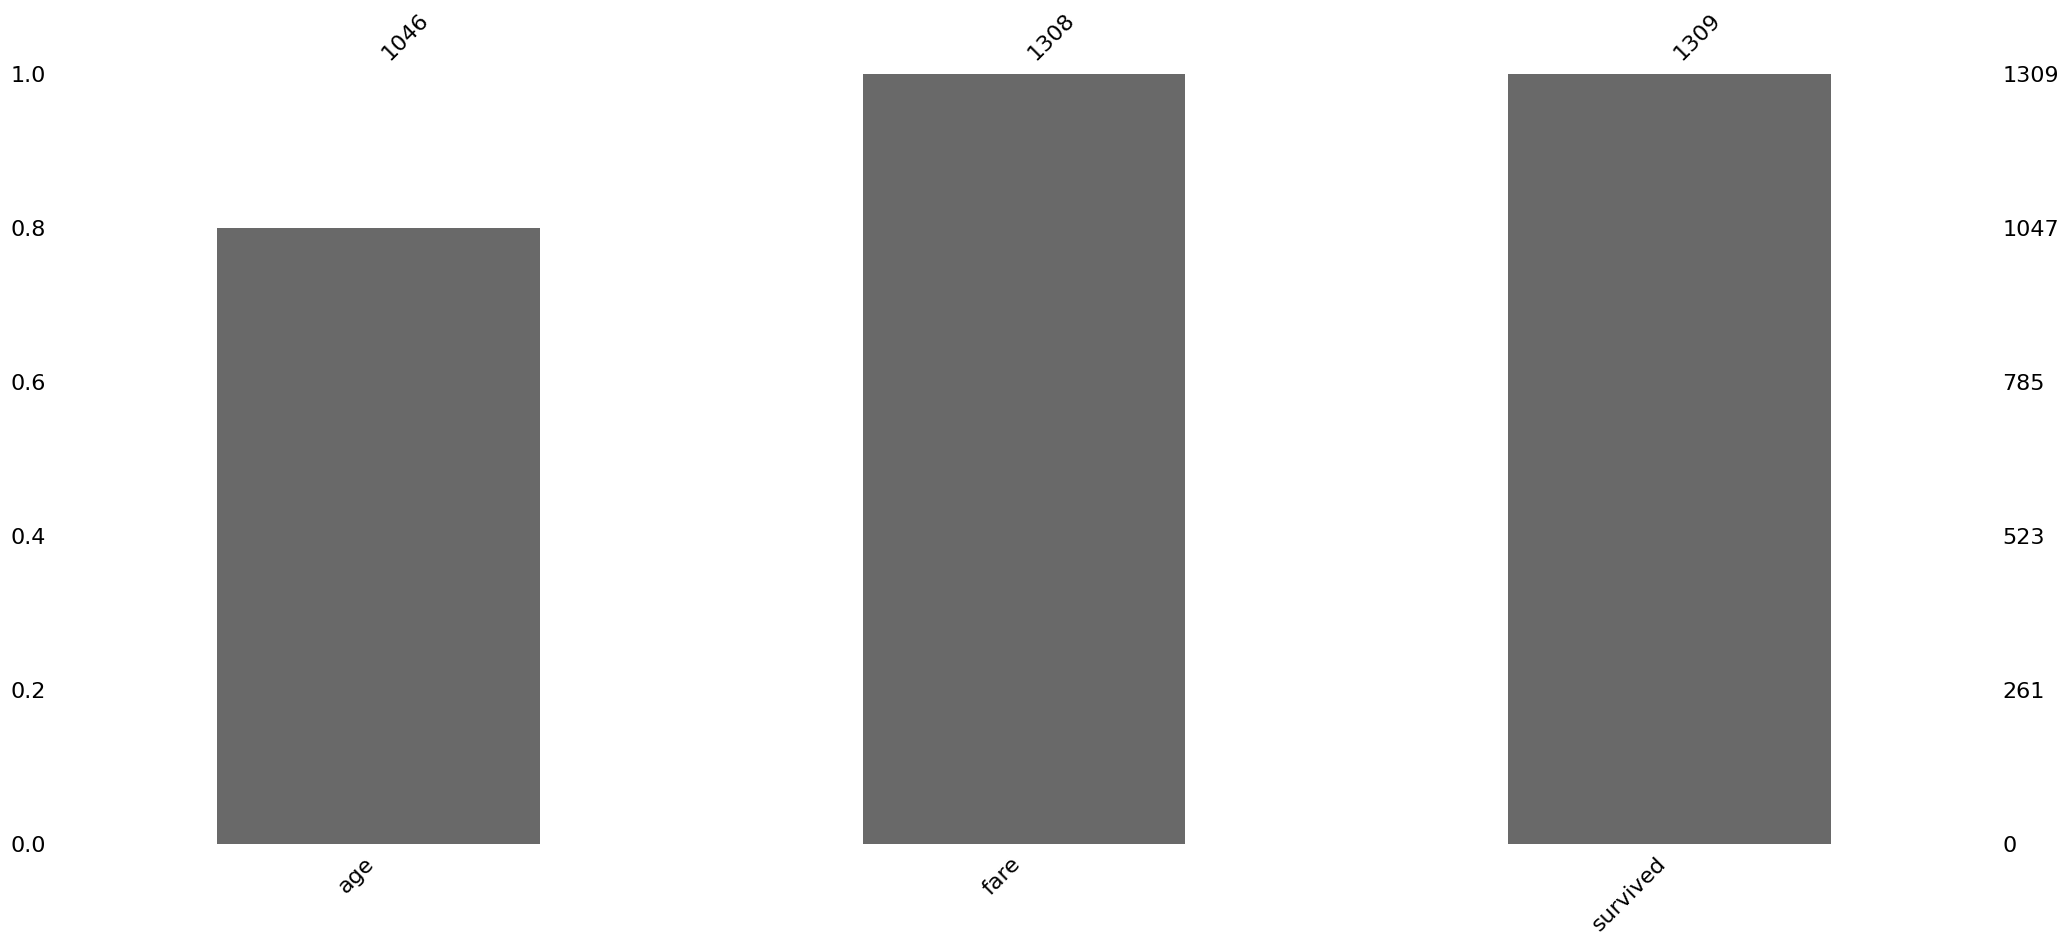

In [6]:
msno.bar(data)

### Method 3: Matrix Plot

The matrix plot is a great tool if you are working with depth-related data or time-series data. It provides a colour fill for each column. 

When data is present, the plot is shaded in grey (or your colour of choice), and when it is absent the plot is displayed in white.


<Axes: >

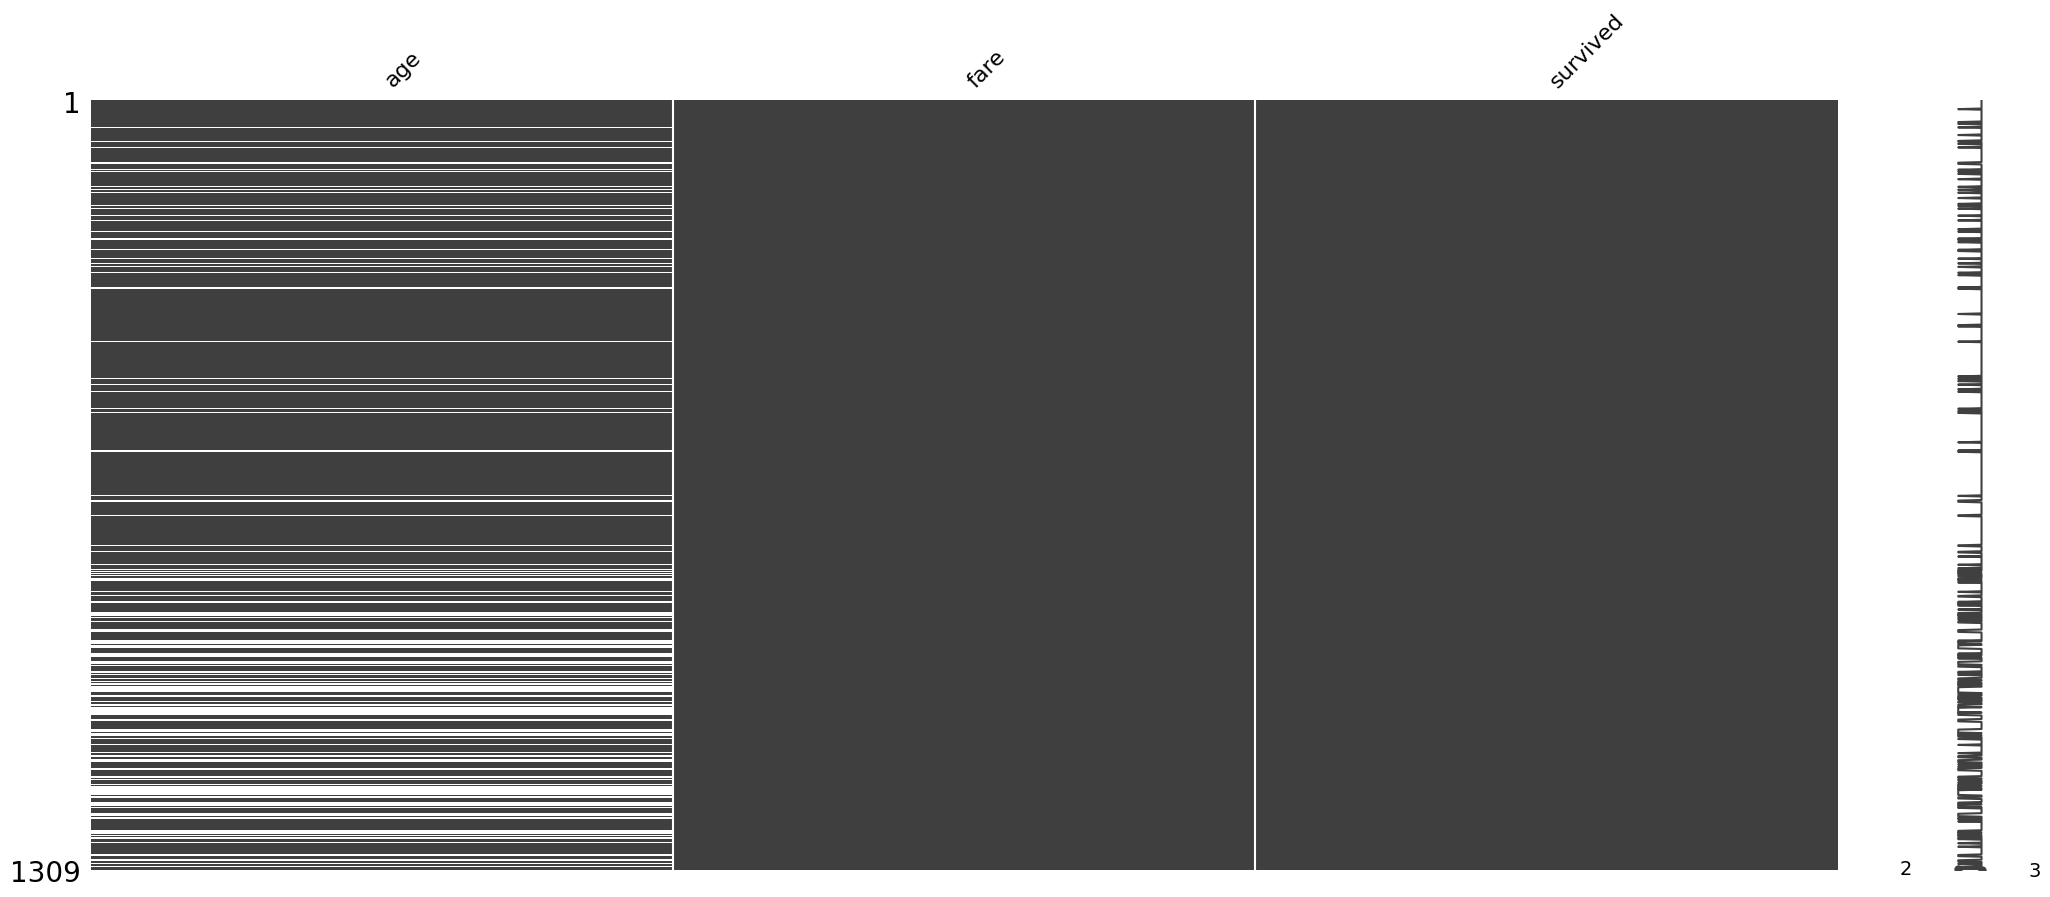

In [7]:
msno.matrix(data)

### Method 4: Correlation Heatmap

The heatmap is used to identify correlations of the nullity between each of the different columns. 

In other words, it can be used to identify if there is a relationship in the presence of null values between each of the columns.

Values close to positive 1 =>
indicate that the presence of null values in one column is correlated with the presence of null values in another column.

Values close to negative 1 =>
indicate that the presence of null values in one column is anti-correlated with the presence of null values in another column (When null values are present in one column, there are data values present in the other column, and vice versa)

Values close to 0 =>
indicate there is little to no relationship between the presence of null values in one column compared to another.

<Axes: >

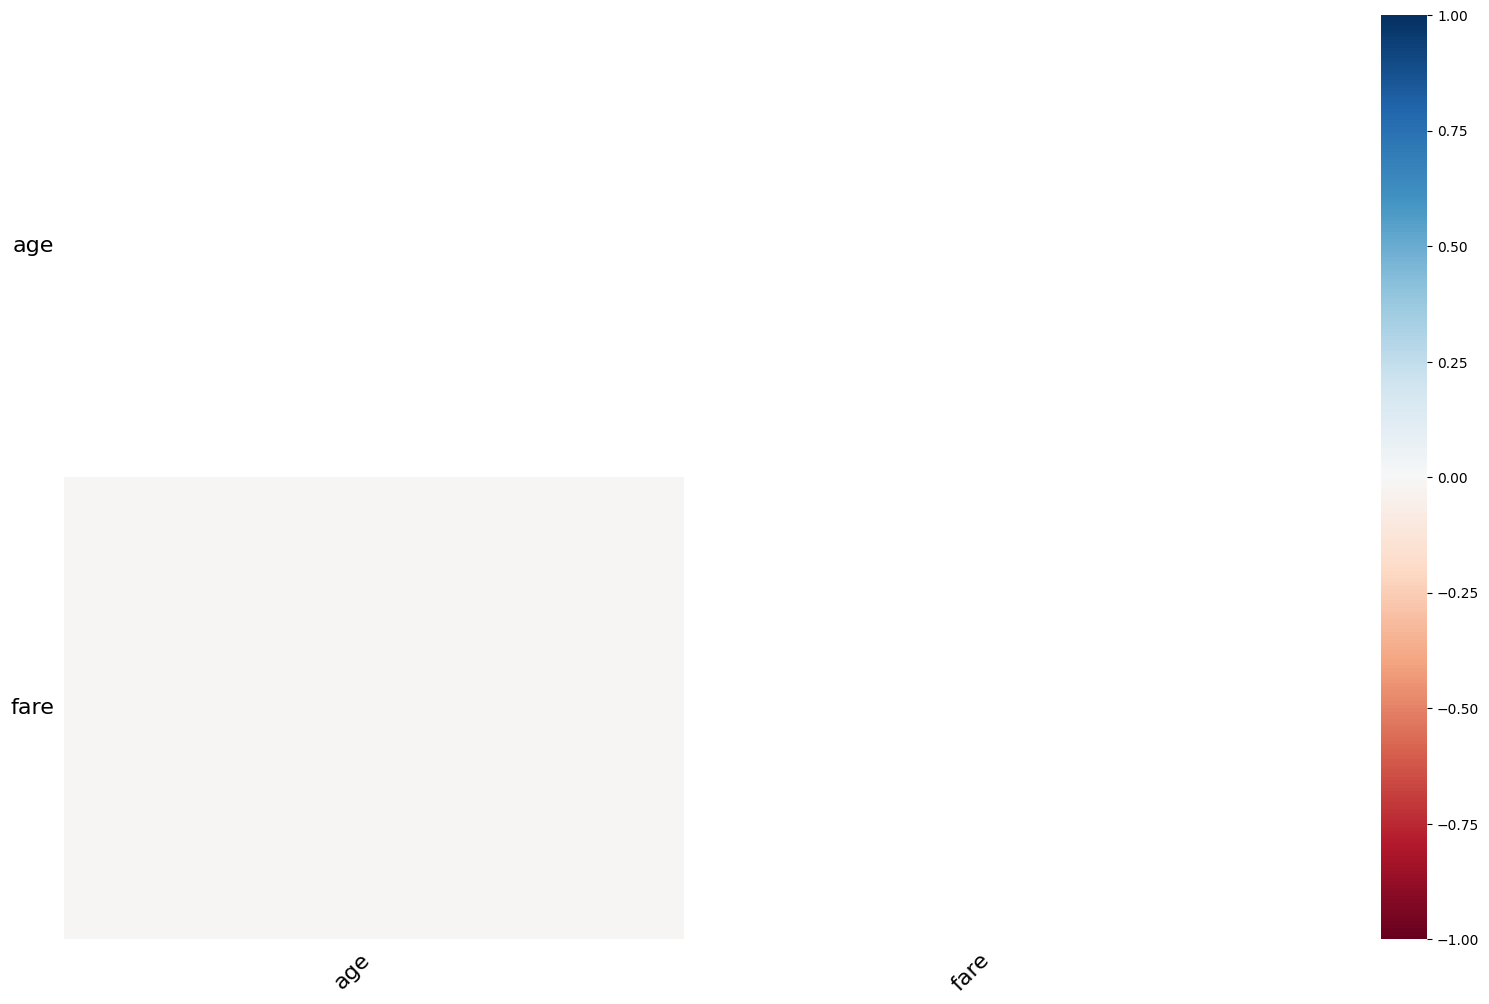

In [8]:
msno.heatmap(data)

# Test for Type of Missingness

## Test for MCAR : Chi Square

H0 : There is no association between the missingness in the target column and the other columns. 

The critical  p-value associated to this test is equal to 0.05.

p-value >= 0.05, H0 stands, no assoc, MCAR

p-value < 0.05, H0 rejected, assoc estimated, not MCAR


In [9]:
# Create missingness indicator variables
data['age_missing'] = data['age'].isnull().astype(int)
data['fare_missing'] = data['fare'].isnull().astype(int)

# Perform chi-squared test to check independence
# The Chi-Square test of independence is used to determine if there is an association between two categorical variables. 
# A contingency table or a crosstab is used by the chi-sq. test to check for the frequency in those categories.
chi2, p, _, _ = chi2_contingency(pd.crosstab(data['age_missing'], data['fare_missing']))
print(f'Chi-Square Value is: {chi2}')


# If the p-value is greater than or equal to the significance level, then we cannot reject the null hypothesis 
# As there is not enough evidence to conclude that there is a significant association between the 2 variables
# Hence, when p-value is > 0.05, the missingness might be within the MCAR-type 
if p < 0.05:
    print("MCAR hypothesis rejected")
else:
    print("MCAR hypothesis not rejected")

Chi-Square Value is: 0.0
MCAR hypothesis not rejected


In [10]:
# Create missingness indicator variables
data['age_missing'] = data['age'].isnull().astype(int)

# Perform chi-squared test to check independence
# The Chi-Square test of independence is used to determine if there is an association between two categorical variables. 
# A contingency table or a crosstab is used by the chi-sq. test to check for the frequency in those categories.
chi2, p, _, _ = chi2_contingency(pd.crosstab(data['age_missing'], data['survived']))
print(f'Chi-Square Value is: {chi2}')


# If the p-value is greater than or equal to the significance level, then we cannot reject the null hypothesis 
# As there is not enough evidence to conclude that there is a significant association between the 2 variables
# Hence, when p-value is > 0.05, the missingness might be within the MCAR-type 
if p < 0.05:
    print("MCAR hypothesis rejected")
else:
    print("MCAR hypothesis not rejected")

Chi-Square Value is: 14.648733705471907
MCAR hypothesis rejected


## Test for MAR

The relationship between the p-value and the coefficient can be summarized as follows:

If the p-value is small (typically less than 0.05), and the coefficient is non-zero, it suggests that the predictor has a statistically significant effect on the response, and the direction (positive or negative) indicates the nature of the relationship.

If the p-value is small (typically less than 0.05), and the coefficient is close to zero, it suggests that the predictor has a statistically significant effect on the response, but the effect may be relatively small.

If the p-value is large (greater than 0.05), and the coefficient is close to zero, it suggests that there's no statistically significant relationship between the predictor and the response.

If the p-value is large (greater than 0.05), and the coefficient is significantly different from zero, it suggests that there's a statistically significant relationship, but the direction of the relationship may be uncertain.

#### M1

In [11]:
# Remove the row with NA in column fare
data = data.dropna(subset=['fare'])

# Create missingness indicator variables
data['age_missing'] = data['age'].isnull().astype(int)

# Train a logistic regression model to predict 'age_missing' based on 'fare' and 'survived'
model = LogisticRegression()
model.fit(data[['fare', 'survived']], data['age_missing'])
coefficients = model.coef_
print(coefficients)

# The coefficients of the model represent the strength and direction of the relationship 
# Between the independent variables (fare and survived) and the dependent variable (age_missing) 
# A positive coefficient indicates that the independent variable is positively associated with the dependent variable, 
# While a negative coefficient indicates that the independent variable is negatively associated with the dependent variable.
if coefficients[0][0] != 0 or coefficients[0][1] != 0:
    print("MAR hypothesis rejected")
else:
    print("MAR hypothesis not rejected")

[[-0.01208688 -0.37909957]]
MAR hypothesis rejected


#### M2

In [19]:
data = data_original.copy()
data = data[["age", "fare", "survived"]]

# Create missingness indicator variables
data['age_missing'] = data['age'].isnull().astype(int)
data = data.dropna(subset=['fare'])

data['fare'] = pd.to_numeric(data['fare'])
data['survived'] = pd.to_numeric(data['survived'])
data['age_missing'] = pd.to_numeric(data['age_missing'])

data.head()


,age,fare,survived,age_missing
0,29,211.3375,1,0
1,0.9167,151.5500,1,0
2,2,151.5500,0,0
3,30,151.5500,0,0
4,25,151.5500,0,0


In [21]:
X = data[['fare', 'survived']] # Features
y = data['age_missing']  # Target variable

# X = sm.add_constant(X)
logit_model = sm.Logit(y, X)

result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.520192
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            age_missing   No. Observations:                 1308
Model:                          Logit   Df Residuals:                     1306
Method:                           MLE   Df Model:                            1
Date:                Wed, 01 Nov 2023   Pseudo R-squ.:                -0.03648
Time:                        08:12:14   Log-Likelihood:                -680.41
converged:                       True   LL-Null:                       -656.46
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
fare          -0.0339      0.003     -9.831      0.000      -0.041      -0.027
survived      -0.8177      0.

# Data Imputation

In [66]:
data = data_original.copy()
data = data[["age", "fare", "survived"]]

data = data.dropna(subset=['fare'])

data['age'] = pd.to_numeric(data['age'])

data.head()

,age,fare,survived
0,29.0000,211.3375,1
1,0.9167,151.55,1
2,2.0000,151.55,0
3,30.0000,151.55,0
4,25.0000,151.55,0


In [80]:
X_train, X_test, y_train, y_test = train_test_split(
    data[["age", "fare"]],  # predictors
    data["survived"],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0,
)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1046, 2), (262, 2))

In [75]:
data.isnull().sum().sort_values(ascending=False)/len(data)*100

age         20.107034
fare         0.000000
survived     0.000000
dtype: float64

### Method 1: Mean/Median

In [71]:
# First, replace with the median.
X_train["Age_median"] = X_train["age"].fillna(X_train.age.median())

# Now replace with the mean.
X_train["Age_mean"] = X_train["age"].fillna(X_train.age.mean())

X_train.head()

,age,fare,imputed_age,Age_mean_SK,Age_median_SK,Age_median,Age_mean
406,40.0,26,40.0,40.0,40.0,40.0,40.0
44,41.0,134.5,41.0,41.0,41.0,41.0,41.0
1235,74.0,7.775,74.0,74.0,74.0,74.0,74.0
785,22.0,13.9,22.0,22.0,22.0,22.0,22.0
794,5.0,12.475,5.0,5.0,5.0,5.0,5.0


In [70]:
# Using Scikit-Learn

# Create a new column to store the imputed values
X_train["Age_mean_SK"] = None
X_train["Age_median_SK"] = None

# Impute the missing values in the "age" column
imputer = SimpleImputer(strategy="mean")
imputed_age = imputer.fit_transform(X_train)
X_train["Age_mean_SK"] = imputed_age

# Impute the missing values in the "age" column
imputer = SimpleImputer(strategy="median")
imputed_age = imputer.fit_transform(X_train)
X_train["Age_median_SK"] = imputed_age

X_train

c:\Users\megat\Anaconda3\envs\personal_finance\lib\site-packages\sklearn\impute\_base.py:558: UserWarning: Skipping features without any observed values: ['Age_mean_SK' 'Age_median_SK']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
c:\Users\megat\Anaconda3\envs\personal_finance\lib\site-packages\sklearn\impute\_base.py:558: UserWarning: Skipping features without any observed values: ['Age_median_SK']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


,age,fare,imputed_age,Age_mean_SK,Age_median_SK
406,40.0000,26,40.000000,40.000000,40.0000
44,41.0000,134.5,41.000000,41.000000,41.0000
1235,74.0000,7.775,74.000000,74.000000,74.0000
785,22.0000,13.9,22.000000,22.000000,22.0000
794,5.0000,12.475,5.000000,5.000000,5.0000
...,...,...,...,...,...
763,0.1667,20.575,0.166700,0.166700,0.1667
835,NaN,8.05,30.054827,30.054827,28.0000
1216,NaN,7.7333,30.054827,30.054827,28.0000
559,20.0000,36.75,20.000000,20.000000,20.0000


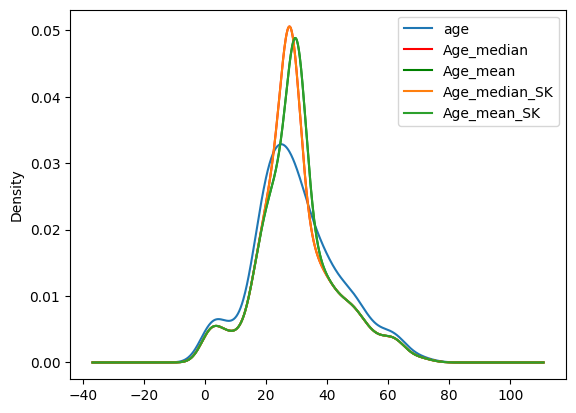

In [72]:
fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train["age"].plot(kind="kde", ax=ax)

# variable imputed with the median
X_train["Age_median"].plot(kind="kde", ax=ax, color="red")

# variable imputed with the mean
X_train["Age_mean"].plot(kind="kde", ax=ax, color="green")

# variable imputed with the median
X_train["Age_median_SK"].plot(kind="kde", ax=ax)

# variable imputed with the mean
X_train["Age_mean_SK"].plot(kind="kde", ax=ax)


# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc="best")

<Axes: >

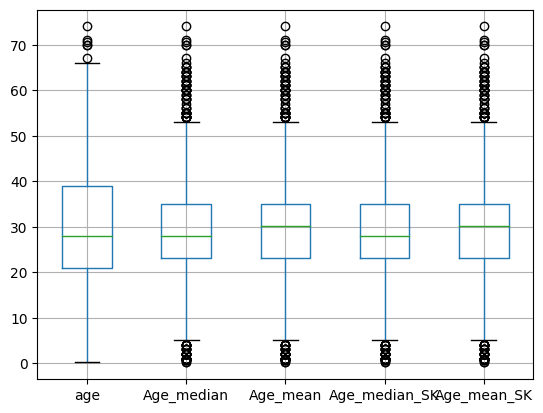

In [73]:
# Let's find out using a boxplot.
X_train[["age", "Age_median", "Age_mean", "Age_median_SK", "Age_mean_SK"]].boxplot()

### Method 2: Arbitrary Imputation

In [76]:
imputation_dict = {
    "age": 999
}

# Replace missing data
X_train.fillna(imputation_dict, inplace=True)


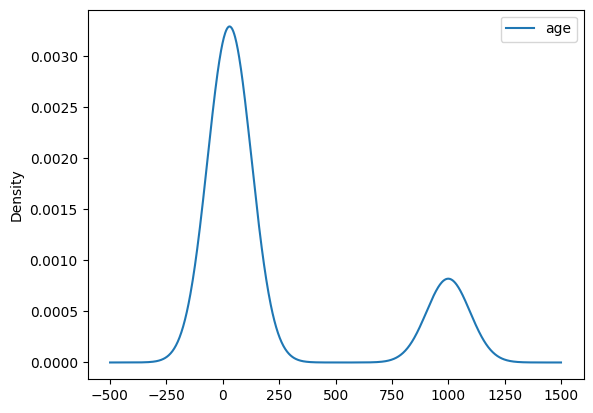

In [77]:
fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train["age"].plot(kind="kde", ax=ax)


# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc="best")

### Method 3: Random Imputation

In [81]:
vars_na = [var for var in X_train.columns if X_train[var].isnull().sum() > 0]

for var in vars_na:

    # extract the random sample to fill the na:
    # remember we do this always from the train set, and we use
    # these to fill both train and test

    random_sample_train = (
        X_train[var].dropna().sample(X_train[var].isnull().sum(), random_state=0)
    )

    # what is all of the above code doing?

    # 1) dropna() removes the NA from the original variable, this
    # means that I will randomly extract existing values and not NAs

    # 2) sample() is the method that will do the random sampling

    # 3) X_train[var].isnull().sum() is the number of random values to extract
    # I want to extract as many values as NAs are present in the original variable

    # 4) random_state sets the seed for reproducibility, so that I extract
    # always the same random values, every time I run this notebook

    # pandas needs to have the same index in order to merge datasets
    random_sample_train.index = X_train[X_train[var].isnull()].index

    # replace the NA in the newly created variable
    X_train.loc[X_train[var].isnull(), var] = random_sample_train

In [84]:
X_train["age_new"] = X_train["age"]

random_sample_train = (
    X_train["age_new"].dropna().sample(X_train["age_new"].isnull().sum(), random_state=0)
)

# pandas needs to have the same index in order to merge datasets
random_sample_train.index = X_train[X_train["age_new"].isnull()].index

# replace the NA in the newly created variable
X_train.loc[X_train["age_new"].isnull(), "age_new"] = random_sample_train

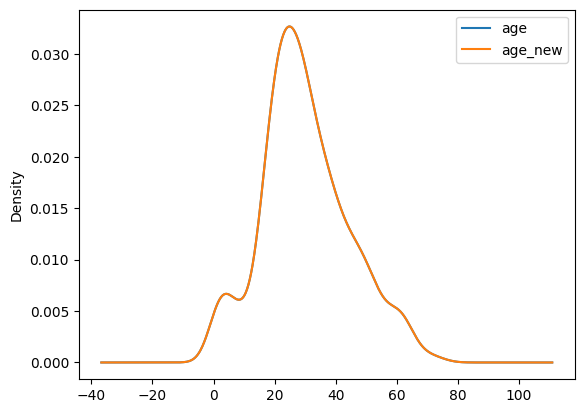

In [85]:
fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train["age"].plot(kind="kde", ax=ax)
X_train["age_new"].plot(kind="kde", ax=ax)

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc="best")

<Axes: >

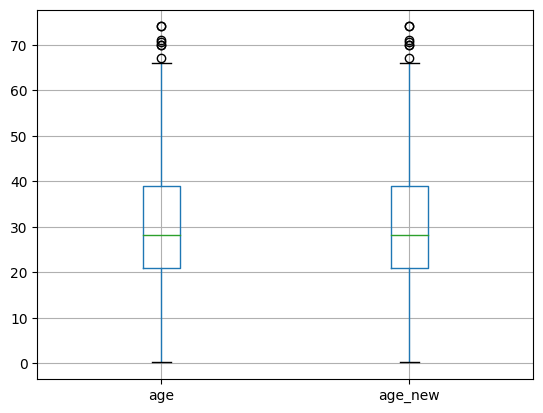

In [86]:
# Let's find out using a boxplot.
X_train[["age","age_new"]].boxplot()

### Method 4: 

### Method 5: 